# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [1]:
# run this once to unzip the file
!unzip processed-celeba-small.zip

Archive:  processed-celeba-small.zip
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response []
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
import pathlib
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
#from torchvision.io import read_image

import tests

In [9]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [10]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # TODO: edit this function by appening transforms to the below list
    transforms = [Resize(size), ToTensor(), Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]
    
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [11]:
# Getting the list of images was inspired by a post at the link below
# https://stackoverflow.com/questions/3964681/find-all-files-in-a-directory-with-extension-txt-in-python
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        # TODO: implement the init method
        self.img_dir = directory
        self.transform = transforms
        self.extension = extension
        self.img_list = list(pathlib.Path(self.img_dir).glob('*'+self.extension))

    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        # TODO: return the number of elements in the dataset
        return len(self.img_list)

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        # TODO: return the index-element of the dataset
        img_file = self.img_list[index]
        img = Image.open(img_file)
        if self.transform != None:
            img = self.transform(img)
        return img

In [12]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

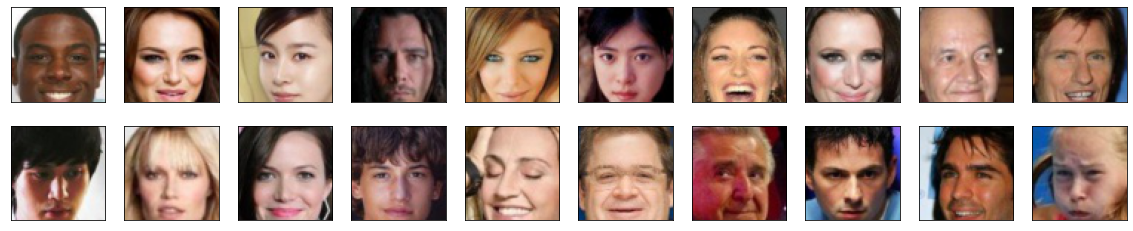

In [13]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [14]:
import torch.nn as nn
from torch.nn import Module

In [15]:
conv_dim = 64

In [16]:
class ConvBlock(Module):
    """
    A convolutional block is made of 3 layers: Conv -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - batch_norm: whether to use batch norm or not
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, batch_norm: bool = True):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [17]:
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # 64x64 input
        self.conv1 = ConvBlock(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 32x32 out
        self.conv2 = ConvBlock(conv_dim, conv_dim*2, 4)
        # 16x16 out
        self.conv3 = ConvBlock(conv_dim*2, conv_dim*4, 4)
        # 8x8 out
        self.conv4 = ConvBlock(conv_dim*4, conv_dim*8, 4)
        # 4x4 out
        
        self.flatten = nn.Flatten()
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*8*4*4, 1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        # all hidden layers + leaky relu activation
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten
        x = self.flatten(x)
        # final output layer
        x = self.fc(x)
        return x.view(1,1,1,-1) 

In [18]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [19]:
class DeconvBlock(Module):
    """
    A "de-convolutional" block is made of 3 layers: ConvTranspose -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - stride: stride of the conv layer
    - padding: padding of the conv layer
    - batch_norm: whether to use batch norm or not
    """
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: int, 
                 stride: int,
                 padding: int,
                 batch_norm: bool = True):
        super(DeconvBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.deconv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [20]:
class Generator(Module):
    def __init__(self, latent_dim: int):
        super(Generator, self).__init__()
        
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(latent_dim,conv_dim*8*4*4) 
        
        self.deconv1 = DeconvBlock(conv_dim*8, conv_dim*4, 2, 2, 0)
        self.deconv2 = DeconvBlock(conv_dim*4, conv_dim*2, 2, 2, 0)
        self.deconv3 = DeconvBlock(conv_dim*2, conv_dim, 2, 2, 0)
        self.deconv4 = nn.ConvTranspose2d(conv_dim, 3, 2, stride=2, padding=0)
        self.last_activation = nn.Tanh()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        x = self.fc(x)
        x = x.view(-1, conv_dim*8, 4,4)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.last_activation(x)
        return x

In [21]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [22]:
import torch.optim as optim

# params provided in lecture notes
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # TODO: implement the generator and discriminator optimizers
    g_optimizer = optim.Adam(generator.parameters(), lr, [beta1, beta2])
    d_optimizer = optim.Adam(discriminator.parameters(), lr, [beta1, beta2])
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [23]:
# Added this to avoid changing the provided interfaces
smooth = 0.9

In [24]:
def generator_loss(fake_logits):
    """ Generator loss, takes the fake scores as inputs. """
    # TODO: implement the generator loss
    # https://knowledge.udacity.com/questions/964412 and https://knowledge.udacity.com/questions/911586
    labels = torch.ones(fake_logits.size())*smooth
    #labels = torch.ones_like(fake_logits)*smooth
    labels = labels.to(device)
        
    criterion = nn.BCEWithLogitsLoss()
    # squeeze tensor to get a single score
    loss = criterion(fake_logits.squeeze(), labels.squeeze())
    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [25]:
def discriminator_loss(real_logits, fake_logits):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    # TODO: implement the discriminator loss
    
    labels_r = torch.ones(real_logits.size())*smooth
    labels_r = labels_r.to(device)
    criterion = nn.BCEWithLogitsLoss()
    loss_r = criterion(real_logits.squeeze(), labels_r.squeeze())
    
    labels_f = torch.zeros(fake_logits.size())
    labels_f = labels_f.to(device)
    loss_f = criterion(fake_logits.squeeze(), labels_f.squeeze())
    
    loss = loss_r + loss_f
    return loss

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [26]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    """ This function enforces """
    gp = 0
    # TODO (Optional): implement the gradient penalty
    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [27]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """ One training step of the generator. """
    # TODO: implement the generator step (foward pass, loss calculation and backward pass)
    
    g_optimizer.zero_grad()
        
    # Generate fake images
    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    z = torch.from_numpy(z).float()
    z = z.to(device)
    fake_images = generator(z)
    
    g_optimizer.zero_grad()
    
    D_fake = discriminator(fake_images)
    g_loss = generator_loss(D_fake) 

    # perform backprop
    g_loss.backward()
    g_optimizer.step()
    return {'loss': g_loss}


def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor) -> Dict:
    """ One training step of the discriminator. """
    # TODO: implement the discriminator step (foward pass, loss calculation and backward pass)
    
    d_optimizer.zero_grad()
        
    # Compute the discriminator losses on real images 
    
    real_images = real_images.to(device)

    D_real = discriminator(real_images)

    # Generate fake images
    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    z = torch.from_numpy(z).float()
    z = z.to(device)
    fake_images = generator(z)

    # Compute the discriminator losses on fake images            
    D_fake = discriminator(fake_images)
    
    d_loss = discriminator_loss(D_real, D_fake)

    # add up loss and perform backprop
    d_loss.backward()
    d_optimizer.step()
    return {'loss': d_loss, 'gp': 0}

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [28]:
from datetime import datetime

In [29]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# Note that I have to use the CPU to a workspace issue from the system update on June 29
# RuntimeError: Found no NVIDIA driver on your system. 
# Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

# update to cpu if you do not have access to a gpu
device = 'cuda'

# number of epochs to train your model
n_epochs = 10

# number of images in each batch
batch_size = 64

In [30]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [38]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

2023-06-30 15:51:13 | Epoch [1/10] | Batch 0/509 | d_loss: 1.7216 | g_loss: 0.5834
2023-06-30 15:53:58 | Epoch [1/10] | Batch 50/509 | d_loss: 0.3445 | g_loss: 4.9370
2023-06-30 15:56:41 | Epoch [1/10] | Batch 100/509 | d_loss: 0.3449 | g_loss: 6.0820
2023-06-30 15:59:25 | Epoch [1/10] | Batch 150/509 | d_loss: 0.3361 | g_loss: 5.9867
2023-06-30 16:02:09 | Epoch [1/10] | Batch 200/509 | d_loss: 0.3688 | g_loss: 6.6246
2023-06-30 16:04:59 | Epoch [1/10] | Batch 250/509 | d_loss: 0.3396 | g_loss: 6.0745
2023-06-30 16:07:45 | Epoch [1/10] | Batch 300/509 | d_loss: 0.7890 | g_loss: 3.6320
2023-06-30 16:10:32 | Epoch [1/10] | Batch 350/509 | d_loss: 0.4430 | g_loss: 3.3079
2023-06-30 16:13:14 | Epoch [1/10] | Batch 400/509 | d_loss: 0.4139 | g_loss: 4.9996
2023-06-30 16:15:53 | Epoch [1/10] | Batch 450/509 | d_loss: 0.4513 | g_loss: 3.1026
2023-06-30 16:18:36 | Epoch [1/10] | Batch 500/509 | d_loss: 0.4013 | g_loss: 3.0928


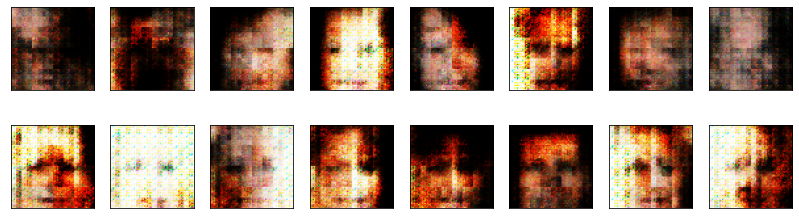

2023-06-30 16:19:08 | Epoch [2/10] | Batch 0/509 | d_loss: 0.4329 | g_loss: 3.4461
2023-06-30 16:21:51 | Epoch [2/10] | Batch 50/509 | d_loss: 0.5051 | g_loss: 3.2041
2023-06-30 16:24:33 | Epoch [2/10] | Batch 100/509 | d_loss: 0.5747 | g_loss: 4.9702
2023-06-30 16:27:07 | Epoch [2/10] | Batch 150/509 | d_loss: 0.4856 | g_loss: 2.6807
2023-06-30 16:29:42 | Epoch [2/10] | Batch 200/509 | d_loss: 0.3996 | g_loss: 5.3773
2023-06-30 16:32:25 | Epoch [2/10] | Batch 250/509 | d_loss: 0.4389 | g_loss: 3.6510
2023-06-30 16:35:06 | Epoch [2/10] | Batch 300/509 | d_loss: 0.4027 | g_loss: 4.5258
2023-06-30 16:37:46 | Epoch [2/10] | Batch 350/509 | d_loss: 0.4936 | g_loss: 4.2321
2023-06-30 16:40:25 | Epoch [2/10] | Batch 400/509 | d_loss: 0.5190 | g_loss: 3.2981
2023-06-30 16:43:05 | Epoch [2/10] | Batch 450/509 | d_loss: 0.4048 | g_loss: 3.6279
2023-06-30 16:45:41 | Epoch [2/10] | Batch 500/509 | d_loss: 0.9630 | g_loss: 7.7727


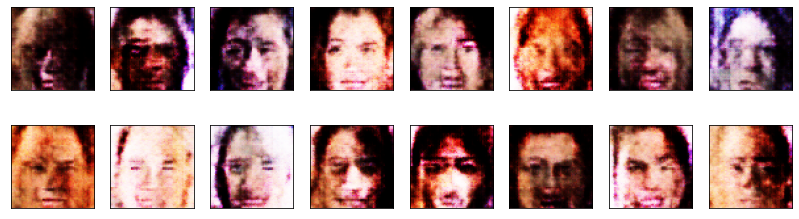

2023-06-30 16:46:11 | Epoch [3/10] | Batch 0/509 | d_loss: 0.4354 | g_loss: 3.4946
2023-06-30 16:48:52 | Epoch [3/10] | Batch 50/509 | d_loss: 0.6419 | g_loss: 2.4087
2023-06-30 16:51:36 | Epoch [3/10] | Batch 100/509 | d_loss: 0.3993 | g_loss: 4.3208
2023-06-30 16:54:19 | Epoch [3/10] | Batch 150/509 | d_loss: 0.4363 | g_loss: 3.2866
2023-06-30 16:57:08 | Epoch [3/10] | Batch 200/509 | d_loss: 0.4381 | g_loss: 4.2883
2023-06-30 16:59:49 | Epoch [3/10] | Batch 250/509 | d_loss: 0.4590 | g_loss: 4.1201
2023-06-30 17:02:31 | Epoch [3/10] | Batch 300/509 | d_loss: 0.3921 | g_loss: 3.9501
2023-06-30 17:05:10 | Epoch [3/10] | Batch 350/509 | d_loss: 0.4330 | g_loss: 3.3257
2023-06-30 17:07:47 | Epoch [3/10] | Batch 400/509 | d_loss: 0.5169 | g_loss: 2.5003
2023-06-30 17:10:27 | Epoch [3/10] | Batch 450/509 | d_loss: 0.4249 | g_loss: 3.4420
2023-06-30 17:13:05 | Epoch [3/10] | Batch 500/509 | d_loss: 0.4743 | g_loss: 2.7662


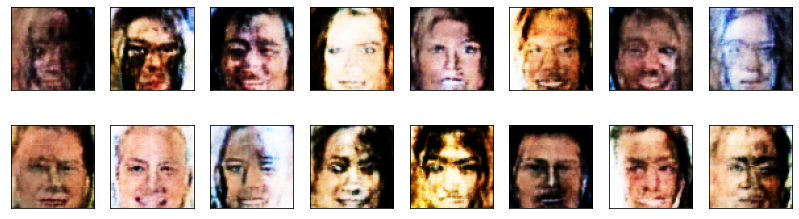

2023-06-30 17:13:36 | Epoch [4/10] | Batch 0/509 | d_loss: 0.8149 | g_loss: 1.5192
2023-06-30 17:16:16 | Epoch [4/10] | Batch 50/509 | d_loss: 0.4111 | g_loss: 3.5920
2023-06-30 17:18:56 | Epoch [4/10] | Batch 100/509 | d_loss: 0.3971 | g_loss: 3.7130
2023-06-30 17:21:43 | Epoch [4/10] | Batch 150/509 | d_loss: 0.6291 | g_loss: 4.6292
2023-06-30 17:24:23 | Epoch [4/10] | Batch 200/509 | d_loss: 0.4181 | g_loss: 3.8576
2023-06-30 17:27:04 | Epoch [4/10] | Batch 250/509 | d_loss: 0.4323 | g_loss: 4.1561
2023-06-30 17:29:37 | Epoch [4/10] | Batch 300/509 | d_loss: 0.3870 | g_loss: 3.4068
2023-06-30 17:32:14 | Epoch [4/10] | Batch 350/509 | d_loss: 0.3651 | g_loss: 3.7725
2023-06-30 17:34:51 | Epoch [4/10] | Batch 400/509 | d_loss: 0.3771 | g_loss: 4.2053
2023-06-30 17:37:27 | Epoch [4/10] | Batch 450/509 | d_loss: 0.3853 | g_loss: 4.7078
2023-06-30 17:40:10 | Epoch [4/10] | Batch 500/509 | d_loss: 0.4069 | g_loss: 4.5406


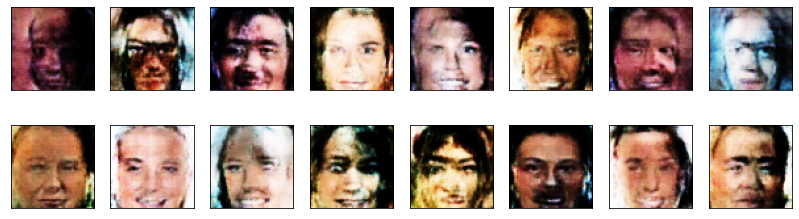

2023-06-30 17:40:42 | Epoch [5/10] | Batch 0/509 | d_loss: 0.7943 | g_loss: 1.8014
2023-06-30 17:43:18 | Epoch [5/10] | Batch 50/509 | d_loss: 0.4044 | g_loss: 4.3016
2023-06-30 17:46:01 | Epoch [5/10] | Batch 100/509 | d_loss: 0.4263 | g_loss: 3.5023
2023-06-30 17:48:45 | Epoch [5/10] | Batch 150/509 | d_loss: 0.7301 | g_loss: 6.4924
2023-06-30 17:51:26 | Epoch [5/10] | Batch 200/509 | d_loss: 0.4271 | g_loss: 5.2068
2023-06-30 17:54:05 | Epoch [5/10] | Batch 250/509 | d_loss: 0.8953 | g_loss: 1.8900
2023-06-30 17:56:51 | Epoch [5/10] | Batch 300/509 | d_loss: 0.4188 | g_loss: 4.2743
2023-06-30 17:59:33 | Epoch [5/10] | Batch 350/509 | d_loss: 0.4381 | g_loss: 4.6213
2023-06-30 18:02:17 | Epoch [5/10] | Batch 400/509 | d_loss: 0.4759 | g_loss: 3.7307
2023-06-30 18:04:59 | Epoch [5/10] | Batch 450/509 | d_loss: 0.5049 | g_loss: 3.3942
2023-06-30 18:07:44 | Epoch [5/10] | Batch 500/509 | d_loss: 0.5976 | g_loss: 5.6589


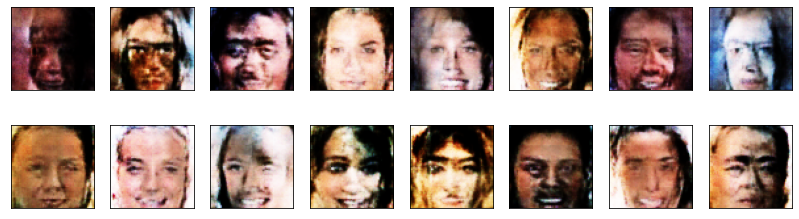

2023-06-30 18:08:14 | Epoch [6/10] | Batch 0/509 | d_loss: 0.3936 | g_loss: 3.9541
2023-06-30 18:10:49 | Epoch [6/10] | Batch 50/509 | d_loss: 0.4233 | g_loss: 4.1700
2023-06-30 18:13:22 | Epoch [6/10] | Batch 100/509 | d_loss: 0.3793 | g_loss: 4.6983
2023-06-30 18:15:55 | Epoch [6/10] | Batch 150/509 | d_loss: 0.4282 | g_loss: 5.1590
2023-06-30 18:18:32 | Epoch [6/10] | Batch 200/509 | d_loss: 0.4247 | g_loss: 3.3195
2023-06-30 18:21:08 | Epoch [6/10] | Batch 250/509 | d_loss: 0.4727 | g_loss: 2.7660
2023-06-30 18:23:53 | Epoch [6/10] | Batch 300/509 | d_loss: 0.3967 | g_loss: 3.9833
2023-06-30 18:26:37 | Epoch [6/10] | Batch 350/509 | d_loss: 0.4283 | g_loss: 5.0692
2023-06-30 18:29:25 | Epoch [6/10] | Batch 400/509 | d_loss: 0.3769 | g_loss: 4.4389
2023-06-30 18:32:07 | Epoch [6/10] | Batch 450/509 | d_loss: 0.3627 | g_loss: 4.9275
2023-06-30 18:34:50 | Epoch [6/10] | Batch 500/509 | d_loss: 0.4590 | g_loss: 3.0446


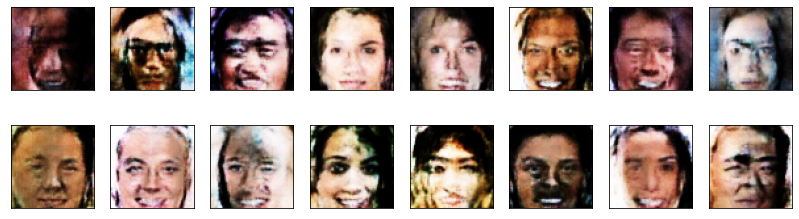

2023-06-30 18:35:24 | Epoch [7/10] | Batch 0/509 | d_loss: 0.3607 | g_loss: 4.2584
2023-06-30 18:38:18 | Epoch [7/10] | Batch 50/509 | d_loss: 0.3974 | g_loss: 5.2749
2023-06-30 18:41:01 | Epoch [7/10] | Batch 100/509 | d_loss: 0.3765 | g_loss: 3.2274
2023-06-30 18:43:41 | Epoch [7/10] | Batch 150/509 | d_loss: 0.3889 | g_loss: 4.2137
2023-06-30 18:46:24 | Epoch [7/10] | Batch 200/509 | d_loss: 0.3886 | g_loss: 4.5946
2023-06-30 18:49:02 | Epoch [7/10] | Batch 250/509 | d_loss: 0.4513 | g_loss: 3.3360
2023-06-30 18:51:42 | Epoch [7/10] | Batch 300/509 | d_loss: 0.3636 | g_loss: 4.7016
2023-06-30 18:54:26 | Epoch [7/10] | Batch 350/509 | d_loss: 0.3838 | g_loss: 3.9318
2023-06-30 18:57:05 | Epoch [7/10] | Batch 400/509 | d_loss: 0.4228 | g_loss: 3.8247
2023-06-30 18:59:46 | Epoch [7/10] | Batch 450/509 | d_loss: 0.3860 | g_loss: 3.3834
2023-06-30 19:02:23 | Epoch [7/10] | Batch 500/509 | d_loss: 0.5260 | g_loss: 2.2066


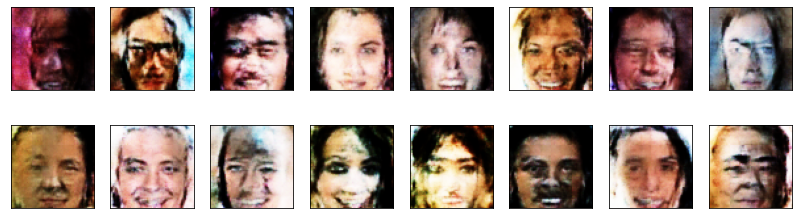

2023-06-30 19:02:54 | Epoch [8/10] | Batch 0/509 | d_loss: 0.3703 | g_loss: 3.9837
2023-06-30 19:05:30 | Epoch [8/10] | Batch 50/509 | d_loss: 0.3979 | g_loss: 3.7835
2023-06-30 19:08:04 | Epoch [8/10] | Batch 100/509 | d_loss: 0.3640 | g_loss: 4.3650
2023-06-30 19:10:38 | Epoch [8/10] | Batch 150/509 | d_loss: 0.4473 | g_loss: 4.7272
2023-06-30 19:13:13 | Epoch [8/10] | Batch 200/509 | d_loss: 1.6652 | g_loss: 0.7933
2023-06-30 19:15:51 | Epoch [8/10] | Batch 250/509 | d_loss: 0.3821 | g_loss: 4.3177
2023-06-30 19:18:25 | Epoch [8/10] | Batch 300/509 | d_loss: 0.4254 | g_loss: 5.5402
2023-06-30 19:21:00 | Epoch [8/10] | Batch 350/509 | d_loss: 0.3807 | g_loss: 3.7006
2023-06-30 19:23:40 | Epoch [8/10] | Batch 400/509 | d_loss: 0.5940 | g_loss: 4.5019
2023-06-30 19:26:20 | Epoch [8/10] | Batch 450/509 | d_loss: 0.3663 | g_loss: 4.2445
2023-06-30 19:28:58 | Epoch [8/10] | Batch 500/509 | d_loss: 0.3509 | g_loss: 4.8432


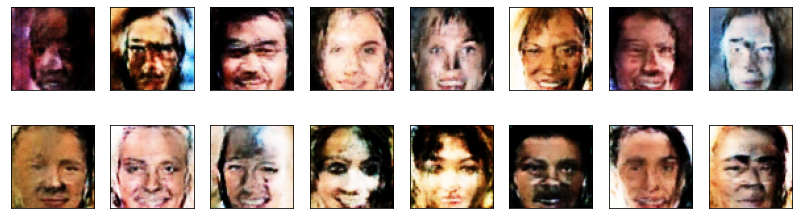

2023-06-30 19:29:29 | Epoch [9/10] | Batch 0/509 | d_loss: 0.3639 | g_loss: 5.3448
2023-06-30 19:32:17 | Epoch [9/10] | Batch 50/509 | d_loss: 0.4274 | g_loss: 3.9463
2023-06-30 19:35:01 | Epoch [9/10] | Batch 100/509 | d_loss: 0.3576 | g_loss: 4.7134
2023-06-30 19:37:36 | Epoch [9/10] | Batch 150/509 | d_loss: 0.3604 | g_loss: 4.4618
2023-06-30 19:40:09 | Epoch [9/10] | Batch 200/509 | d_loss: 0.3845 | g_loss: 3.8704
2023-06-30 19:42:47 | Epoch [9/10] | Batch 250/509 | d_loss: 0.3511 | g_loss: 4.0685
2023-06-30 19:45:20 | Epoch [9/10] | Batch 300/509 | d_loss: 0.4166 | g_loss: 3.0129
2023-06-30 19:47:53 | Epoch [9/10] | Batch 350/509 | d_loss: 0.3720 | g_loss: 4.2206
2023-06-30 19:50:32 | Epoch [9/10] | Batch 400/509 | d_loss: 0.3494 | g_loss: 4.7947
2023-06-30 19:53:03 | Epoch [9/10] | Batch 450/509 | d_loss: 0.3508 | g_loss: 5.2300
2023-06-30 19:55:38 | Epoch [9/10] | Batch 500/509 | d_loss: 0.5454 | g_loss: 4.0991


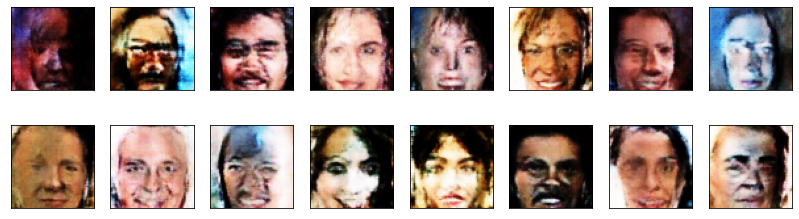

2023-06-30 19:56:08 | Epoch [10/10] | Batch 0/509 | d_loss: 0.4633 | g_loss: 2.4258
2023-06-30 19:58:41 | Epoch [10/10] | Batch 50/509 | d_loss: 0.4733 | g_loss: 4.9902
2023-06-30 20:01:20 | Epoch [10/10] | Batch 100/509 | d_loss: 0.3488 | g_loss: 5.3905
2023-06-30 20:03:48 | Epoch [10/10] | Batch 150/509 | d_loss: 0.5546 | g_loss: 2.6641
2023-06-30 20:06:20 | Epoch [10/10] | Batch 200/509 | d_loss: 0.3550 | g_loss: 5.1123
2023-06-30 20:08:53 | Epoch [10/10] | Batch 250/509 | d_loss: 0.3900 | g_loss: 5.6876
2023-06-30 20:11:22 | Epoch [10/10] | Batch 300/509 | d_loss: 0.4089 | g_loss: 3.5370
2023-06-30 20:13:54 | Epoch [10/10] | Batch 350/509 | d_loss: 0.3625 | g_loss: 5.1020
2023-06-30 20:16:35 | Epoch [10/10] | Batch 400/509 | d_loss: 0.4104 | g_loss: 3.1289
2023-06-30 20:19:06 | Epoch [10/10] | Batch 450/509 | d_loss: 0.3912 | g_loss: 4.4583
2023-06-30 20:21:42 | Epoch [10/10] | Batch 500/509 | d_loss: 0.3647 | g_loss: 4.3928


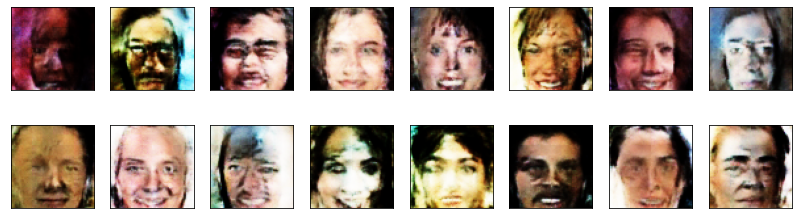

In [42]:
#fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float()

losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)

        ####################################

        # TODO: implement the training strategy

        ####################################

        g_loss = generator_step(batch_size, latent_dim)
        d_loss = discriminator_step(batch_size, latent_dim, real_images)

        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')

    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

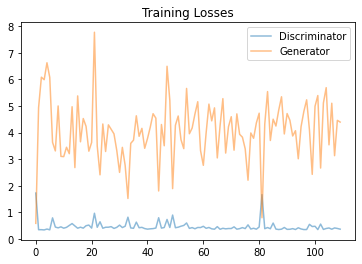

In [43]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** The generated samples tended to be relatively clear near the centre of the images.  This is somewhat expected as eyes, ears, and mouth are all relatively common featues among people, especially given the pre-processing of the images.  An interesting result is that the model clearly had difficulty generating darker skinned images (i.e. the top left).  As the input images are mostly caucasian, the GAN struggled to generate realistic darker skinned people. 

The DCGAN based model that was used was also relatively small and simple, given the problem.  Additional convolutional layers (possibly combined with higher resultion images) could help extract more features from the training images.  I also only have a single linear layer in the generator and discriminator.  Adding more linear layers could improver performance.

It is clear that more epochs are required to generate more realistic images however with the current architecture, little improvement was made over the final epochs.  Another possible modification is to use a slightly higher learning rate for the discriminator.  Additionaly, we can do a 3-1 ratio of discriminator to generator updates.  I did try running the latter and the model more quickly converged to semi-realistic images, but the end result was not substantially more realisitc.     

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.